In [1]:
%matplotlib inline

import sys
sys.path.append('/storage2/andrey/code/vrAnalysis/')

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import gaussian_kde
from scipy import stats as scipystats
from scipy import signal, interpolate
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES
from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_figure_size, get_extent
from analysis.models.analytics import gaussian_kernel_2D

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def get_trajectory_in_arena_rf(h5file):
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        arena_trajectory = np.array(f['arena_trajectory'])

    # bring to arena coordinate system
    a_min, a_max = arena_trajectory[:, 2].min(), arena_trajectory[:, 2].max()
    arena_trajectory[:, 2] -= a_min
    trajectory[:, 2] -= arena_trajectory[:len(trajectory), 2] - ( (a_max - a_min)/2 )
    
    return trajectory

In [4]:
def get_occ_and_speed(sessions_list, bin_size=0.03):
    # get a session for common variables
    animal, session = sessions_list[0][0], sessions_list[0][1]
    occupancies = []
    speeds = []

    # use first session to get common params
    h5file = os.path.join(source, animal, session, 'all.h5')
    trajectory = get_trajectory_in_arena_rf(h5file)
    conditions = get_epochs(os.path.join(source, animal, session))

    kernel = gaussian_kernel_2D(0.1)
    
    # let's set the same for all
    #limits = get_figure_size(trajectory[:, 1:3])
    #extent = get_extent(trajectory[:, 1:3])
    #x_min, x_max = trajectory[:, 1].min(), trajectory[:, 1].max()
    #y_min, y_max = trajectory[:, 2].min(), trajectory[:, 2].max()
    
    extent = (-0.4, 0.4, -0.85, 0.85)
    limits = (extent[0] - 0.1, extent[1] + 0.1, extent[2] - 0.1, extent[3] + 0.1)
    x_min, x_max, y_min, y_max = extent
    
    pos_range = np.array([[x_min, x_max], [y_min, y_max]])

    x_range = x_max - x_min
    y_range = y_max - y_min
    y_bin_count = int(np.ceil(y_range / bin_size))
    x_bin_count = int(np.ceil(x_range / bin_size))

    for animal, session, s_type in [s for s in sessions_list]:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')

        if not os.path.exists(h5file):
            continue

        trajectory = get_trajectory_in_arena_rf(h5file) 
        sampling_rate = float(round((np.ones(len(trajectory) - 1)/np.diff(trajectory[:, 0])).mean()))

        occup_temp = {}
        speed_temp = {}
        for i, cond in enumerate(conditions):
            with h5py.File(h5file, 'r') as f:
                cond_idxs = np.array(f['%s_idxs' % cond])
                velocity = np.array(f['velocity'])
                velocity = np.append(velocity, [velocity[-1]], axis=0)
                #trajectory = np.array(f['animal_trajectory'])[:, 3]  # t, x, y

            #diffs = np.diff(trajectory[:, :3], axis=0)
            #velocity_Y = diffs[:, 2] / diffs[:, 0]  # dy/dt, only Y-component of the velocity
            #velocity_Y = np.sqrt(np.square(diffs[:, 1]) + np.square(diffs[:, 2])) / diffs[:, 0]  # real velocity
            #velocity_Y = np.append(velocity_Y, 0)
            #weights = velocity_Y[cond_idxs]
            
            pos = trajectory[cond_idxs]
            weights = velocity[cond_idxs][:, 1]  # real velocity
            
            occup, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], range=pos_range)
            speed, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], density=True, weights=weights, range=pos_range)

            occup_temp[cond] = occup / sampling_rate
            #print(sampling_rate, len(pos)/(60.*sampling_rate), len(trajectory)/(60.*sampling_rate), occup_temp[cond].sum())
            #speed_temp[cond] = np.nan_to_num(speed/occup_temp[cond])
            speed_temp[cond] = speed/occup_temp[cond]

        occupancies.append(occup_temp)
        speeds.append(speed_temp)

    # sum across sessions within each condition
    occ_all = {}
    for cond in conditions:
        selection = [occ[cond] for occ in occupancies if cond in occ]
        occ_sum = reduce((lambda x, y: x + y), selection)
        occ_all[cond] = occ_sum/len(selection)

    speed_all = {}
    for cond in conditions:
        colnan = [sp[cond] for sp in speeds if cond in sp]

        result = []
        n, m = np.array(colnan[0]).shape
        for i in range(n):
            for j in range(m):
                result.append(np.nanmean( [x[i, j] for x in colnan] ))

        result = np.array(result)
        result[np.isnan(result)] = 0.
        result = np.reshape(np.array(result), (-1, m))        
        
        #speed_all[cond] = sp_sum/len(selection)        
        speed_all[cond] = result/float(len(colnan))
        
    return conditions, occ_all, speed_all, extent, limits

In [5]:
def plot_arena_stats(maps, extent, limits, titles, hlines=[], cbar_label=''):
    fig = figure(figsize=(2*len(maps), 4))
    kernel = gaussian_kernel_2D(0.1)

    vmax = np.array([signal.convolve2d(occ, kernel, mode='same').max() for occ in maps.values()]).max()
    collected = []
    for i, cond in enumerate(sorted(maps.keys())):
        occupancy_map = maps[cond]
        occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

        ax = fig.add_subplot(1, len(maps.keys()), i+1)
        ax.set_xticks([])
        if i > 0:
            ax.set_yticklabels([])
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.grid()
        ax.set_title(titles[i], fontsize=14)
        for hline in hlines:
            ax.axhline(hline, color=COLORS['a'], ls='--')
        posPFA = ax.imshow(np.flip(occupancy_map.T, axis=1), cmap='jet', origin='lower', extent=extent,\
                               vmax=vmax, alpha=1)
        collected.append(np.flip(occupancy_map.T, axis=1))

    cax = fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar = plt.colorbar(posPFA, cax=cax) # Similar to fig.colorbar(im, cax = cax)
    cbar.set_label(cbar_label, fontsize=14)
    
    return collected, fig

In [6]:
def is_periodic(session_path):
    params = get_params_from_json(session_path)
    return int(params['vr']['scene']['move_interval']) < 60

## Fetch sessions and define functions to get occupancy/speed/theta modulation

In [9]:
COLORS = get_colors()

#source = '/home/andrey/storage2/andrey/data/processed'
source = '/storage2/andrey/data/processed'
#paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  #'002784', 

In [10]:
names_short = {
    'SHIFT periodic +dark': 'P',
    'SHIFT single +dark': 'S',
    'SHIFT both +dark': 'C',
    'SHIFT visual +dark': 'Vs',
    'SHIFT visual long +dark': 'Vl',
    'GAIN 3 parts 1.2x': 'Gs',
    'GAIN 3 parts 1.4x': 'Gl'
}
early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

# Gradual influence of the physical versus the visual geometry on the spatal representation

### Occupancy / speed - SINGLE / PERIODIC shift

In [11]:
conditions, occ_all_ps, speed_all_ps, extent, limits = get_occ_and_speed(periodic + single)  
# merge with single? there will be bias in speed for the B then

# merge dark into one condition
conditions = ('A', 'B', 'D')
occ_all_ps['D'] = occ_all_ps['Ad'] + occ_all_ps['Bd']
del occ_all_ps['Ad']
del occ_all_ps['Bd']
speed_all_ps['D'] = speed_all_ps['Ad']
del speed_all_ps['Ad']
del speed_all_ps['Bd']

/tmp/ipykernel_841/908396407.py:66: RuntimeWarning: invalid value encountered in divide
  speed_temp[cond] = speed/occup_temp[cond]
/tmp/ipykernel_841/908396407.py:86: RuntimeWarning: Mean of empty slice
  result.append(np.nanmean( [x[i, j] for x in colnan] ))


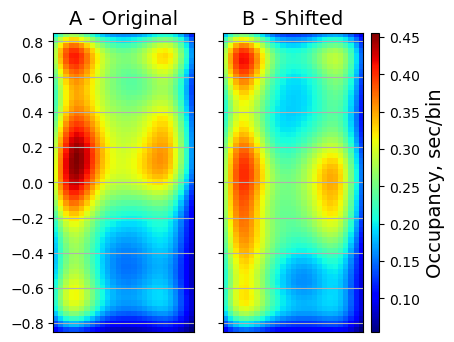

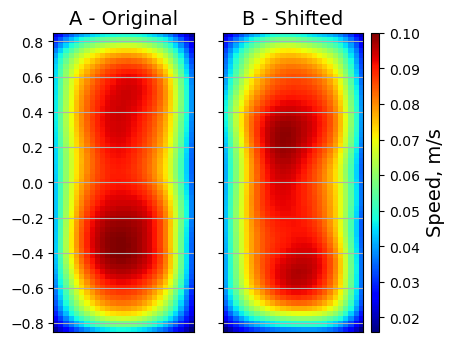

In [12]:
titles = ['A - Original', 'B - Shifted', 'D - Dark', 'B - A']
limits = (extent[0], extent[1], extent[2], extent[3])

occ_all_p = occ_all_ps.copy()
speed_all_p = speed_all_ps.copy()
del speed_all_p['D']
del occ_all_p['D']

#occ_all_p['zAB'] = occ_all_p['B'] - occ_all_p['A']
occ_plotted, fig = plot_arena_stats(occ_all_p, extent, limits, titles, cbar_label='Occupancy, sec/bin')
filename = "1d_1.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

spd_plotted, fig = plot_arena_stats(speed_all_p, extent, limits, titles, cbar_label='Speed, m/s')
filename = "1d_2.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

### Occupancy / speed - COHERENT shift

In [32]:
conditions, occ_all_coh, speed_all_coh, extent, limits = get_occ_and_speed(coherent)  

# consider only A-B here
conditions = ('A', 'B')
del occ_all_coh['Ad']
del occ_all_coh['Bd']
del speed_all_coh['Ad']
del speed_all_coh['Bd']

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


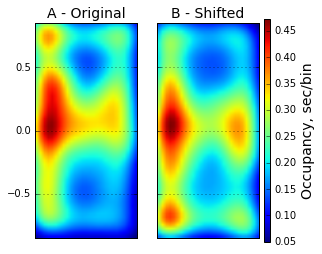

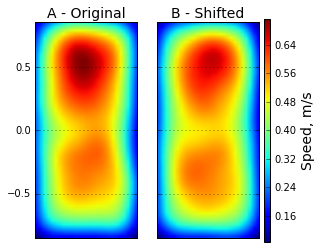

In [54]:
titles = ['A - Original', 'B - Shifted', 'D - Dark', 'B - A']
limits = (extent[0], extent[1], extent[2], extent[3])

occ_all_p = occ_all_coh.copy()
speed_all_p = speed_all_coh.copy()
occ_plotted, fig = plot_arena_stats(occ_all_p, extent, limits, titles, cbar_label='Occupancy, sec/bin')
filename = "E_2b_1.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

spd_plotted, fig = plot_arena_stats(speed_all_p, extent, limits, titles, cbar_label='Speed, m/s')
filename = "E_2b_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

In [9]:
def get_xy(occ_map, x_left, x_right):
    kernel_1D = signal.gaussian(100, std=15)
    x_binned = np.linspace(x_left, x_right, occ_map.shape[1])
    y_binned = occ_map.sum(axis=0)/occ_map.shape[0]
    x_new = np.linspace(x_left, x_right, 500)
    f = interp1d(x_binned, y_binned)
    
    y_new = np.concatenate([np.ones(100)*y_binned[0], f(x_new), np.ones(100)*y_binned[-1]])
    y_new = np.convolve(y_new, kernel_1D, 'same') / kernel_1D.sum()
    y_new = y_new[100:-100]    
    
    #y_new = np.convolve(f(x_new), kernel_1D, 'same') / kernel_1D.sum()
    return x_new, y_new

In [12]:
# getting occupancy maps and collecting Y-profiles, SLOW
dist = 0.42
profiles_A = []
profiles_B = []
for ss in (periodic + single):
    try:
        _, occ, speed, ext, lims = get_occ_and_speed([ss])
    except:
        print(ss)
        continue
    
    x_new_A, y_new_A = get_xy(occ['A'], extent[2], extent[3])
    x_new_B, y_new_B = get_xy(occ['B'], extent[2], extent[3])
    profiles_A.append(y_new_A)
    profiles_B.append(y_new_B)

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


['005364', '2020-10-23_12-57-03', 'SHIFT single +dark']


In [13]:
# Occupancy statistics for Y-profiles for NEAR and FAR (fast)
dist = 0.45
near_and_far = []
near_and_far_cs = []
for i in range(len(profiles_A)):
    pcA = profiles_A[i]
    pcB = profiles_B[i]
    y_out_A = pcA[(x_new_A < -dist) | (x_new_A > dist)]
    y_out_B = pcB[(x_new_B < -dist) | (x_new_B > dist)]
    y_ins_A = pcA[(x_new_A > -dist) & (x_new_A < dist)]
    y_ins_B = pcB[(x_new_B > -dist) & (x_new_B < dist)]
    
    near_and_far.append([np.abs(y_out_A - y_out_B).sum(), np.abs(y_ins_A - y_ins_B).sum()])
    
    pcA = (profiles_A[i]/profiles_A[i].sum()).cumsum()
    pcB = (profiles_B[i]/profiles_B[i].sum()).cumsum()
    y_out_A = pcA[(x_new_A < -dist) | (x_new_A > dist)]
    y_out_B = pcB[(x_new_B < -dist) | (x_new_B > dist)]
    y_ins_A = pcA[(x_new_A > -dist) & (x_new_A < dist)]
    y_ins_B = pcB[(x_new_B > -dist) & (x_new_B < dist)]
    
    near_and_far_cs.append([np.abs(y_out_B - y_out_A).sum(), np.abs(y_ins_B - y_ins_A).sum()])

near_and_far = np.array(near_and_far)
near_and_far_cs = np.array(near_and_far_cs)

In [15]:
conditions, occ_all_ps, speed_all_ps, extent, limits = get_occ_and_speed(periodic + single + early_per)  

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


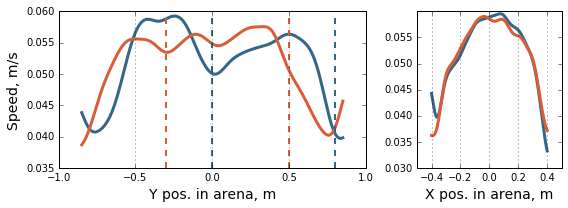

In [25]:
#s1 = occ_all_ps.copy()
s1 = speed_all_ps.copy()
labels = ('A - Original', 'B - Shifted', 'D - Dark')
x_labels = ('X position in arena, m', 'Y pos. in arena, m')
colors = (COLORS['a'], COLORS['b'], COLORS['e'])

fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={
    'width_ratios': [extent[3] - extent[2], extent[1] - extent[0]]})
fig.set_figheight(3)
fig.set_figwidth(8)

lines = []
profile_means = [] # for A and B
for q, cond in enumerate(['A', 'B']):
    x_new, y_new = get_xy(np.flip(s1[cond].T, axis=1), extent[0], extent[1])
    l1, = ax1.plot(x_new, y_new, lw=3, color=colors[q], label=labels[q])
    lines.append(l1)

    x_new, y_new = get_xy(s1[cond], extent[2], extent[3])
    ax0.plot(x_new, y_new, lw=3, color=colors[q], label=labels[q])
    profile_means.append(y_new)

ax0.xaxis.grid()
ax1.xaxis.grid()
ax1.set_xlim(-0.5, 0.5)
vw1 = ax0.axvline(0, color=COLORS['a'], lw=2, ls='--') #, label='Virt. walls A')
vw2 = ax0.axvline(0.8, color=COLORS['a'], lw=2, ls='--')
vw3 = ax0.axvline(0 - 0.3, color=COLORS['b'], lw=2, ls='--') #, label='Virt. walls B')
vw4 = ax0.axvline(0.8 - 0.3, color=COLORS['b'], lw=2, ls='--')
#ax0.set_ylabel('Occupancy, sec/bin', fontsize=14)
ax0.set_ylabel('Speed, m/s', fontsize=14)
ax0.set_xlabel('Y pos. in arena, m', fontsize=14)
ax1.set_xlabel('X pos. in arena, m', fontsize=14)

#first_legend = ax0.legend(handles=lines, loc='lower right', fontsize=14)
#ax0.add_artist(first_legend)
#ax0.legend(handles=[vw1, vw3], loc='lower right', fontsize=14)
#ax0.axvspan(-dist, dist, alpha=0.1, color=COLORS['a'])
#_ = ax0.set_title('N=%s (%s sessions)' % (8, len(periodic + single + early_per)), fontsize=14)


# inset with CDF lines
#left, bottom, width, height = [0.45, 0.2, 0.5, 0.2]
#ax2 = fig.add_axes([left, bottom, width, height])
#ax2.plot(profile_means[0].cumsum())
#ax2.plot(profile_means[1].cumsum())
#ax2.set_xticks([])
#ax2.set_yticks([])

fig.tight_layout()
filename = "1e_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

n=8, p-val=6.9E-10


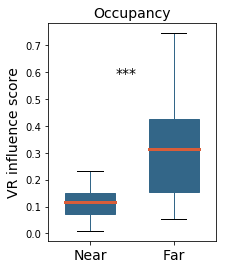

In [25]:
vmax = near_and_far_cs.max()
data = (near_and_far_cs[:, 0]/vmax, near_and_far_cs[:, 1]/vmax)
st, pv = scipystats.wilcoxon(near_and_far_cs[:, 0]/vmax, near_and_far_cs[:, 1]/vmax)

fig = figure(figsize=(3, 4))
ax = fig.add_subplot(111)

c = COLORS['a']
bp = ax.boxplot(data, labels=['Near', 'Far'], widths=0.6, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color='black'),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=COLORS['b'],linewidth=3),
            showfliers=False)

ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel('VR influence score', fontsize=14)
#ax.set_xlabel('Distance to boundary', fontsize=14)
ax.set_title('Occupancy', fontsize=14)
ax.text(1.3, ax.get_ylim()[1] - 0.2, '***', fontsize=14)
#for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
#        plt.setp(box1[item], color=c2)
#plt.setp(box1["boxes"], facecolor=c2)
#plt.setp(box1["fliers"], markeredgecolor=c2)
print("n=8, p-val=%.1E" % pv)

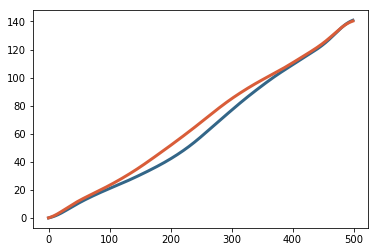

In [26]:
#for p in profiles_A:
#    plt.plot(p.cumsum(), color='black', lw=0.5)
#for p in profiles_B:
#    plt.plot(p.cumsum(), color='red', lw=0.5)

plt.plot(np.array(profiles_A).mean(axis=0).cumsum(), color=COLORS['a'], lw=3)
plt.plot(np.array(profiles_B).mean(axis=0).cumsum(), color=COLORS['b'], lw=3)

# Conflicting conditions do not induce behavioral bias 

### pSHIFT - occupancy relative to the boundaries

- slightly higher occupancy in dark (left plot)
- higher occupancy in the middle in dark (right plot) 

speaks about less fear in darkness

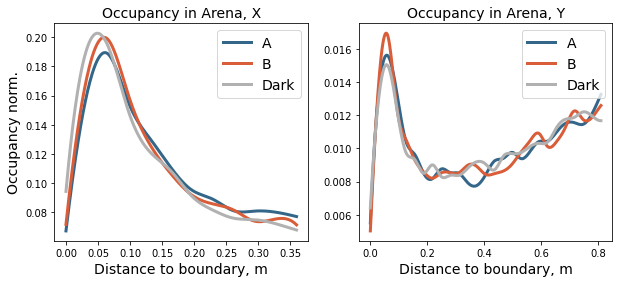

In [82]:
collected_x = {}
collected_y = {}
for cond in sorted(occ_all.keys()):  # watch the order!
    collected_x[cond] = get_occ_vals(occ_all[cond], x_axis=True)
    collected_y[cond] = get_occ_vals(occ_all[cond], x_axis=False)
    
colors = [COLORS['a'], COLORS['b'], '#b1b1b1']
labels = ['A', 'B', 'Dark']

plot_boudary_metric(collected_x, collected_y, colors, labels)

### No change in theta modulation (a bit less in dark?)

In [165]:
animals = ['003281', '003282', '003908', '003909', '005363', '005364']
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')

conditions, collected = get_theta_speed_mod(periodic)

# for periodic - merge dark
collected['D'] = np.concatenate((collected['Ad'], collected['Bd']))
del collected['Ad']
del collected['Bd']

/home/andrey/projects/pyVR/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice.
/home/andrey/projects/pyVR/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


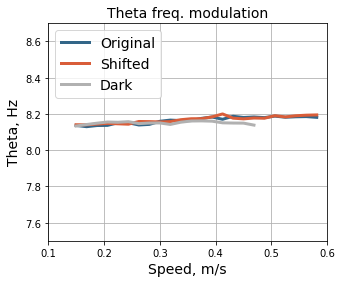

In [166]:
fig = figure(figsize=(5, 4))

bins = np.linspace(0.15, 0.6, 25)
colors = (COLORS['a'], COLORS['b'], '#b1b1b1', COLORS['c'])
labels = ['Original', 'Shifted', 'Dark']

ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(0.1, 0.6)
ax.set_ylim(7.5, 8.7)
ax.grid()
ax.set_xlabel('Speed, m/s', fontsize=14)
ax.set_ylabel('Theta, Hz', fontsize=14)
ax.set_title('Theta freq. modulation', fontsize=14)
    
for i, cond in enumerate(sorted(collected.keys())):
    th_A = np.mean(np.array(collected[cond]), axis=0)  # change to nanmean!
    ax.plot(bins[:-1], th_A, color=colors[i], label=labels[i], lw=3)
    
ax.legend(loc='upper left', fontsize=14)    

### Number of fields per does not depend on the conflict

In [83]:
def get_fields_number(sessions_list):
    # use first session to get common params
    animal, session = sessions_list[-1][0], sessions_list[-1][1]
    conditions = get_epochs(os.path.join(source, animal, session))
    #collected = dict([(cond, []) for cond in conditions])  # empty dict
    collected = []
    
    for animal, session, s_type in sessions_list:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')
        
        if not os.path.exists(h5file):
            continue

        with h5py.File(h5file, 'r') as f:
            units = f['units']
            for unit in units:
                for cond in conditions:
                    if cond in f['units'][unit] and '07_field_patches' in f['units'][unit][cond]:
                        patches = np.array(f['units'][unit][cond]['07_field_patches'])
                        patch_count = len(np.unique(patches)) - 1

                        collected.append([animal, session, unit, cond, patch_count])
    
    columns = ['animal', 'session', 'unit', 'cond', 'count']
    return pd.DataFrame(collected, columns=columns)

In [86]:
collected = get_fields_number(periodic + single)

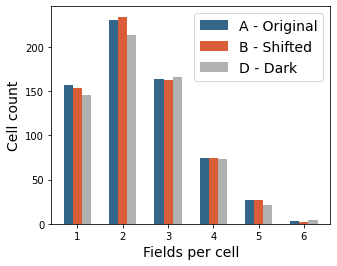

In [88]:
# CDF Place field count per cell A, B, Dark

fcount_A = collected[collected['cond'] == 'A']['count']
fcount_B = collected[collected['cond'] == 'B']['count']
fcount_D = pd.concat([collected[collected['cond'] == 'Ad']['count'], collected[collected['cond'] == 'Bd']['count']])

fhist_A, _ = np.histogram(fcount_A, bins=int(fcount_A.max()))
fhist_B, _ = np.histogram(fcount_B, bins=int(fcount_B.max()))
fhist_D, _ = np.histogram(fcount_D, bins=int(fcount_D.max()))
x = np.arange(len(fhist_A)) + 1
fig = figure(figsize=(5, 4))

ax = fig.add_subplot(111)
ax.bar(x-0.2, fhist_A, width=0.2, color=COLORS['a'], align='center', label='A - Original')
ax.bar(x+0.0, fhist_B, width=0.2, color=COLORS['b'], align='center', label='B - Shifted')
ax.bar(x+0.2, fhist_D[:6]/2, width=0.2, color='#b1b1b1', align='center', label='D - Dark')
ax.set_xlabel('Fields per cell', fontsize=14)
ax.set_ylabel('Cell count', fontsize=14)
#ax.set_title('pSHIFT', fontsize=14)
ax.legend(loc='upper right', fontsize=14)  

### No change in information content / field size in conflicting condition

In [89]:
shift_A_B = get_fields_between_epochs(source, periodic, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, periodic, 'A', 'Ad')

PF match found for 464 fields from total 925 A and 905 B fields
PF match found for 438 fields from total 922 A and 948 Ad fields


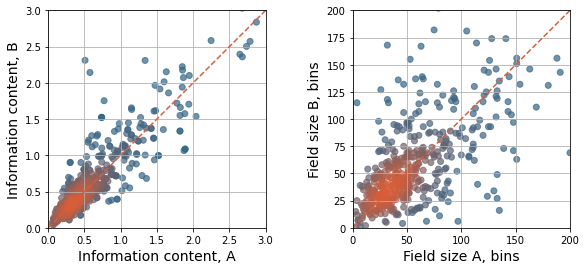

In [90]:
fig = figure(figsize=(10, 4))

# SIC JPDF for field pairs AB, A-Ad
x = shift_A_B['sic_A']
y = shift_A_B['sic_B']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
cvals  = [z2.min(), z2.max()]
colors = [COLORS['a'], COLORS['b']]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(121)
ax.scatter(x2, y2, c=z2, cmap=cmap, norm=norm, alpha=0.7)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.set_xlabel('Information content, A', fontsize=14)
ax.set_ylabel('Information content, B', fontsize=14)
ax.grid()
ax.plot([0, 3], [0, 3], color=COLORS['b'], ls='--')

slope, intercept, r_value, p_value, std_err = scipystats.linregress(x2, y2)


# PF size for field pairs
x = shift_A_B['size_A']
y = shift_A_B['size_B']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x1, y1, z1 = x[idx], y[idx], z[idx]
cvals  = [z1.min(), z1.max()]
colors = [COLORS['a'], COLORS['b']]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(122)
ax.scatter(x1, y1, c=z1, cmap=cmap, norm=norm, alpha=0.7)
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_aspect('equal')
ax.set_xlabel('Field size A, bins', fontsize=14)
ax.set_ylabel('Field size B, bins', fontsize=14)
ax.grid()
ax.plot([0, 200], [0, 200], color=COLORS['b'], ls='--')

### Light reduce in IC in dark

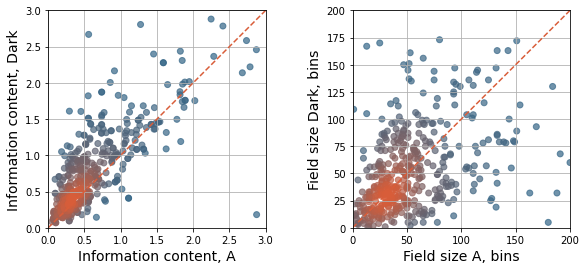

In [91]:
fig = figure(figsize=(10, 4))

# SIC JPDF for field pairs AB, A-Ad
x = shift_A_Ad['sic_A']
y = shift_A_Ad['sic_B']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
cvals  = [z2.min(), z2.max()]
colors = [COLORS['a'], COLORS['b']]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(121)
ax.scatter(x2, y2, c=z2, cmap=cmap, norm=norm, alpha=0.7)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.set_xlabel('Information content, A', fontsize=14)
ax.set_ylabel('Information content, Dark', fontsize=14)
ax.grid()
ax.plot([0, 3], [0, 3], color=COLORS['b'], ls='--')


# PF size for field pairs
x = shift_A_Ad['size_A']
y = shift_A_Ad['size_B']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x1, y1, z1 = x[idx], y[idx], z[idx]
cvals  = [z1.min(), z1.max()]
colors = [COLORS['a'], COLORS['b']]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mcolors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(122)
ax.scatter(x1, y1, c=z1, cmap=cmap, norm=norm, alpha=0.7)
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_aspect('equal')
ax.set_xlabel('Field size A, bins', fontsize=14)
ax.set_ylabel('Field size Dark, bins', fontsize=14)
ax.grid()
ax.plot([0, 200], [0, 200], color=COLORS['b'], ls='--')

# Change in behavior at small / large conflicts - vSHIFT

In [55]:
conditions, occ_all_s, speed_all_s, extent_s, limits_s = get_occ_and_speed(visual_s)
conditions, occ_all_l, speed_all_l, extent_l, limits_l = get_occ_and_speed(visual_l)

# visual s are all periodic
visual_sin_l = [ss for ss in visual_l if not is_periodic(os.path.join(source, ss[0], ss[1]))]
visual_per_l = [ss for ss in visual_l if is_periodic(os.path.join(source, ss[0], ss[1]))]
conditions, occ_sin_l, speed_sin_l, extent_l, limits_l = get_occ_and_speed(visual_sin_l)
conditions, occ_per_l, speed_per_l, extent_l, limits_l = get_occ_and_speed(visual_per_l)

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


### OCCUPANCY / SPEED at small conflicts

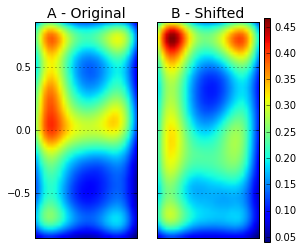

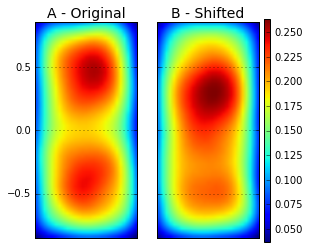

In [56]:
titles = ['A - Original', 'B - Shifted', 'B - A']
limits = (extent[0], extent[1], extent[2], extent[3])

occupancy = occ_all_s.copy()
speed = speed_all_s.copy()
#occupancy['zAB'] = occupancy['B'] - occupancy['A']
#speed['zAB'] = speed['B'] - speed['A']
del occupancy['D']
del speed['D']
maps_plotted, fig = plot_arena_stats(occupancy, extent, limits, titles)
filename = "3f_1.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

maps_plotted, fig = plot_arena_stats(speed, extent, limits, titles)
filename = "3f_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### OCCUPANCY is almost unchanged at large conflicts

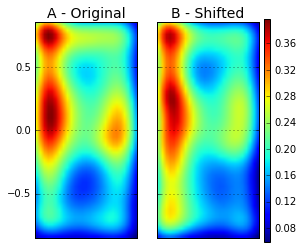

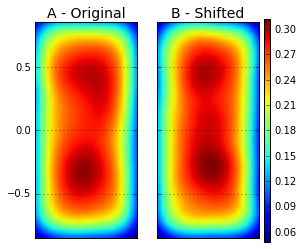

In [49]:
titles = ['A - Original', 'B - Shifted', 'B - A']
limits = (extent[0], extent[1], extent[2], extent[3])

occupancy = occ_all_l.copy()
speed = speed_all_l.copy()
#occupancy['zAB'] = occupancy['B'] - occupancy['A']
#speed['zAB'] = speed['B'] - speed['A']
del occupancy['D']
del speed['D']
maps_plotted, fig = plot_arena_stats(occupancy, extent, limits, titles)
filename = "3f_3.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

maps_plotted, fig = plot_arena_stats(speed, extent, limits, titles)
filename = "3f_4.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### Y-projection (occupancy and speed, A/B)

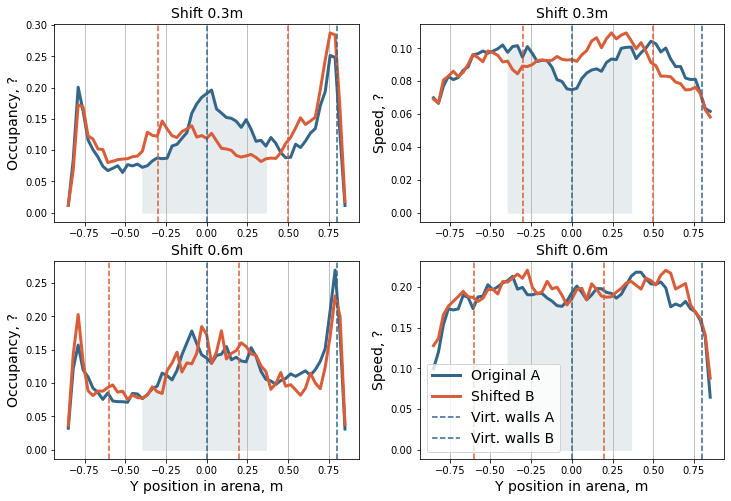

In [97]:
s1 = occ_all_s.copy()
s2 = occ_sin_l.copy()
s3 = speed_all_s.copy()
s4 = speed_sin_l.copy()

fig = figure(figsize=(12, 8))
labels = ['Occupancy, ?', 'Speed, ?']

for i, (occ_s, occ_l) in enumerate(((s1, s2), (s3, s4))):
    x_vals_s = np.linspace(extent[2], extent[3], occ_s['A'].shape[1])
    x_vals_l = np.linspace(extent[2], extent[3], occ_l['A'].shape[1])

    occ_s_A = occ_s['A'].sum(axis=0)/occ_s['A'].shape[1]
    occ_s_B = occ_s['B'].sum(axis=0)/occ_s['B'].shape[1]
    occ_s_D = occ_s['D'].sum(axis=0)/occ_s['D'].shape[1]
    occ_l_A = occ_l['A'].sum(axis=0)/occ_l['A'].shape[1]
    occ_l_B = occ_l['B'].sum(axis=0)/occ_l['B'].shape[1]
    occ_l_D = occ_l['D'].sum(axis=0)/occ_l['D'].shape[1]

    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(x_vals_s, occ_s_A, color=COLORS['a'], lw=3, label='Original A')
    ax.plot(x_vals_s, occ_s_B, color=COLORS['b'], lw=3, label='Shifted B')
    #ax.plot(x_vals_s, occ_s_D, color=COLORS['e'], lw=3, label='Dark D')
    ax.fill_between(x_vals_s[15:41], 0, occ_s_A[15:41], color=COLORS['e'])
    ax.xaxis.grid()
    ax.axvline(0, color=COLORS['a'], ls='--', label='Virt. walls A')    # virtual walls A
    ax.axvline(0.8, color=COLORS['a'], ls='--')  # virtual walls A
    ax.axvline(0 - 0.3, color=COLORS['b'], ls='--', label='Virt. walls B')    # virtual walls A
    ax.axvline(0.8 - 0.3, color=COLORS['b'], ls='--')  # virtual walls A
    #ax.set_xlabel('Y position in arena, m', fontsize=14)
    ax.set_ylabel(labels[i], fontsize=14)
    #ax.set_ylim(0, 0.25)
    ax.set_title('Shift 0.3m', fontsize=14)

    ax = fig.add_subplot(2, 2, i+3)
    ax.plot(x_vals_l, occ_l_A, color=COLORS['a'], lw=3, label='Original A')
    ax.plot(x_vals_l, occ_l_B, color=COLORS['b'], lw=3, label='Shifted B')
    #ax.plot(x_vals_l, occ_l_D, color=COLORS['e'], lw=3)
    ax.fill_between(x_vals_l[15:41], 0, occ_l_A[15:41], color=COLORS['e'])
    ax.xaxis.grid()
    ax.axvline(0, color=COLORS['a'], ls='--', label='Virt. walls A')    # virtual walls A
    ax.axvline(0.8, color=COLORS['a'], ls='--', label='Virt. walls B')  # virtual walls A
    ax.axvline(0 - 0.6, color=COLORS['b'], ls='--')    # virtual walls A
    ax.axvline(0.8 - 0.6, color=COLORS['b'], ls='--')  # virtual walls A
    ax.set_xlabel('Y position in arena, m', fontsize=14)
    ax.set_ylabel(labels[i], fontsize=14)
    if i > 0:
        ax.legend(loc='lower left', fontsize=14)
    ax.set_title('Shift 0.6m', fontsize=14)

In [98]:
# plot for BOTH
# split Single/Periodic 
# look at each session separately!

# Change in behavior at small / large conflicts - vGAIN

In [51]:
conditions_gain, occ_gain_12, speed_gain_12, extent_g_12, limits_g_12 = get_occ_and_speed(gain_12)
conditions_gain, occ_gain_14, speed_gain_14, extent_g_14, limits_g_14 = get_occ_and_speed(gain_14)

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


### OCCUPANCY - 1.2x

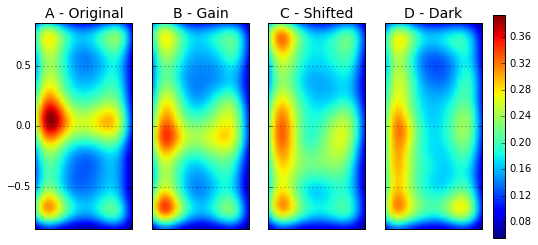

In [52]:
titles = ['A - Original', 'B - Gain', 'C - Shifted', 'D - Dark']
limits = (extent[0], extent[1], extent[2], extent[3])
occ_all = occ_gain_12.copy()
maps_plotted, fig = plot_arena_stats(occ_all, extent, limits, titles)
filename = "4b_1.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### OCCUPANCY - 1.4x

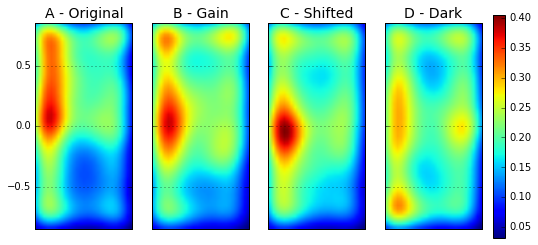

In [53]:
titles = ['A - Original', 'B - Gain', 'C - Shifted', 'D - Dark']
occ_all = occ_gain_14.copy()
maps_plotted, fig = plot_arena_stats(occ_all, extent, limits, titles)
filename = "4b_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### SPEED - 1.2x

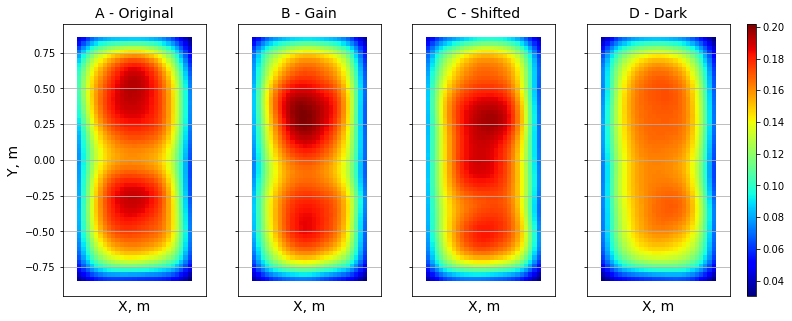

In [102]:
titles = ['A - Original', 'B - Gain', 'C - Shifted', 'D - Dark']
occ_all = speed_gain_12.copy()
maps_plotted = plot_arena_stats(occ_all, extent, limits, titles)

### SPEED - 1.4x

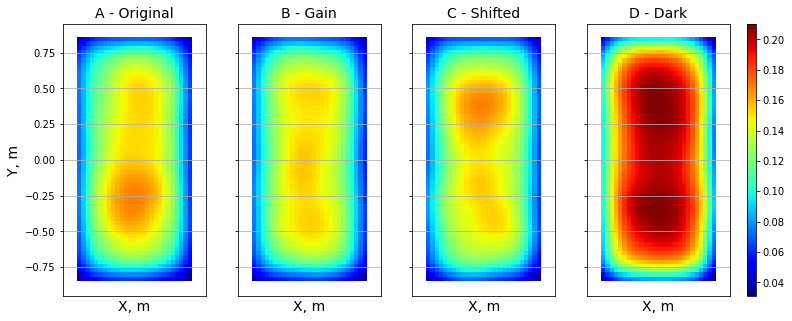

In [103]:
titles = ['A - Original', 'B - Gain', 'C - Shifted', 'D - Dark']
occ_all = speed_gain_14.copy()
maps_plotted = plot_arena_stats(occ_all, extent, limits, titles)

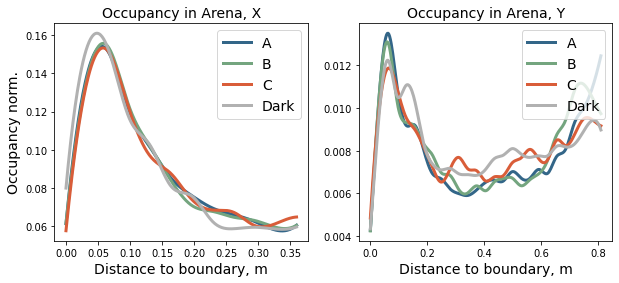

In [104]:
collected_x = {}
collected_y = {}
for cond in sorted(occ_gain_12.keys()):  # watch the order!
    collected_x[cond] = get_occ_vals(occ_gain_12[cond], x_axis=True)
    collected_y[cond] = get_occ_vals(occ_gain_12[cond], x_axis=False)
    
colors = [COLORS['a'], COLORS['c'], COLORS['b'], '#b1b1b1']
labels = ['A', 'B', 'C', 'Dark']

plot_boudary_metric(collected_x, collected_y, colors, labels)

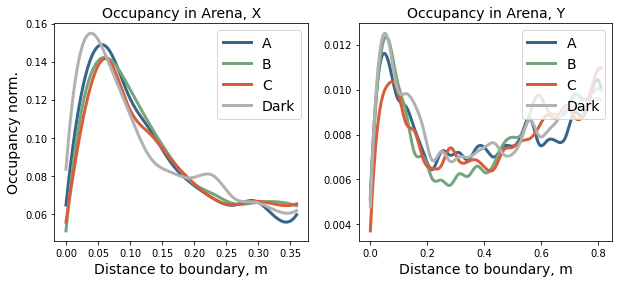

In [105]:
collected_x = {}
collected_y = {}
for cond in sorted(occ_gain_14.keys()):  # watch the order!
    collected_x[cond] = get_occ_vals(occ_gain_14[cond], x_axis=True)
    collected_y[cond] = get_occ_vals(occ_gain_14[cond], x_axis=False)
    
colors = [COLORS['a'], COLORS['c'], COLORS['b'], '#b1b1b1']
labels = ['A', 'B', 'C', 'Dark']

plot_boudary_metric(collected_x, collected_y, colors, labels)

In [419]:
_, th_gain_12 = get_theta_speed_mod(gain_12)
_, th_gain_14 = get_theta_speed_mod(gain_14)

/home/andrey/projects/pyVR/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice.


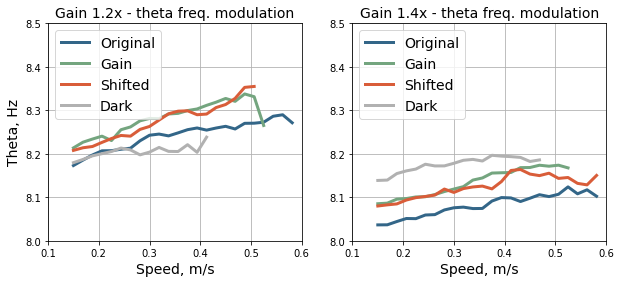

In [421]:
fig = figure(figsize=(10, 4))

bins = np.linspace(0.15, 0.6, 25)
colors = (COLORS['a'], COLORS['c'], COLORS['b'], '#b1b1b1')
labels = ['Original', 'Gain', 'Shifted', 'Dark']
titles = ['1.2x', '1.4x']

for i, data in enumerate([th_gain_12, th_gain_14]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_xlim(0.1, 0.6)
    ax.set_ylim(8, 8.5)
    ax.grid()
    ax.set_xlabel('Speed, m/s', fontsize=14)
    if i == 0:
        ax.set_ylabel('Theta, Hz', fontsize=14)
    ax.set_title('Gain %s - theta freq. modulation' % titles[i], fontsize=14)

    for i, cond in enumerate(sorted(data.keys())):
        th_A = np.mean(np.array(data[cond]), axis=0)  # change to nanmean!
        ax.plot(bins[:-1], th_A, color=colors[i], label=labels[i], lw=3)

    ax.legend(loc='upper left', fontsize=14)    

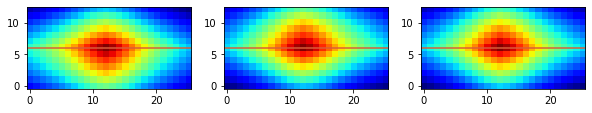

In [210]:
y1, y2 = 18, 38
y1, y2 = 22, 35
corr_AB = signal.correlate2d(maps[1][y1:y2], maps[0][y1:y2], mode='same')
corr_BC = signal.correlate2d(maps[0][y1:y2], maps[1][y1:y2], mode='same')
corr_CD = signal.correlate2d(maps[0][y1:y2], maps[3][y1:y2], mode='same')

fig = figure(figsize=(10, 5))

for i, corr in enumerate([corr_AB, corr_BC, corr_CD]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(corr, cmap='jet', origin='lower')
    ax.axhline(6, color=COLORS['b'])